Non-negative matrix factorization analysis

In [1]:
# python modules
import sys
import copy
import re
import pickle
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.decomposition import NMF

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
### load gtab files
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':None}

dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                           data_path=gtab_path)

loading H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


Done


In [6]:
### set output fname
out_path = './data/'
out_fname = out_path + 'H1_NCP_sp'

In [7]:
# change dkey name
dkey_ID_value['AT content'] = copy.deepcopy(dkey_ID_value['ATcontent'])
del dkey_ID_value['ATcontent']

In [8]:
### compute sequence features
# methylation density
dkey_ID_value['meCpG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CpG)'],
                                                       dkey_ID_value['CNumber(CpG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHG)'],
                                                       dkey_ID_value['CNumber(CHG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHH density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHH)'], 
                                                       dkey_ID_value['CNumber(CHH)'],
                                                       div_error=0.0)


In [9]:
### compute sequence features
# mean poly GC length
ID_polyGC = {}
for ID, seq in dkey_ID_value['Sequence'].items():
    num_pos = statis.polynt_count(seq.upper(), nts='GC', pos=True)
    mean_len, count = 0.0, 0.0
    for num, pos in num_pos.items():
        mean_len += len(pos)*num
        count += len(pos)
    ID_polyGC[ID] = mean_len/count

dkey_ID_value['poly-G/C length'] = ID_polyGC

del dkey_ID_value['Sequence']
del ID_polyGC


In [10]:
### select feature set and target for analysis
seq_features = ['AT content', 'poly-G/C length']
epigenetic_features = ['meCpG density', 'meCHG density', 'meCHH density', 'H2AFZ', 'H2AK5ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac', 'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1', 'H4K5ac', 'H4K8ac', 'H4K91ac']

features = seq_features + epigenetic_features

In [11]:
### set target for analysis
target = 'H1_NCP_sp_8_1rep_deep'

In [12]:
### rescale the feature variables
ID_score = dkey_ID_value[target]
IDs = ID_score.keys()

X = [[] for i in range(len(IDs))]
for feature in features:
    values = [dkey_ID_value[feature][ID] for ID in IDs]
    min_value = min(values)
    max_value = max(values)
    for i in range(len(IDs)):
        value = values[i]
        re_value = float(value-min_value)/max_value
        X[i].append(re_value)
X = scipy.sparse.csr_matrix(X)
del dkey_ID_value

In [13]:
# None-negative matrix factorization
class_num = 10

try:
    with open(out_fname + "_W.pickle", "rb") as f:
        W = pickle.load(f)
    with open(out_fname + "_H.pickle", "rb") as f:
        H = pickle.load(f)

except:
    print "NMF start"
    model = NMF(n_components=class_num, init='random', random_state=0, verbose=True)
    W = model.fit_transform(X)
    H = model.components_
    print "NMF is done"

    with open(out_fname + "_W.pickle", "wb") as f:
        pickle.dump(W, f)
    with open(out_fname + "_H.pickle", "wb") as f:
        pickle.dump(H, f)

NMF start


violation: 1.0
violation: 0.268470829063


violation: 0.0899969156532
violation: 0.0445022543162


violation: 0.0259116783527
violation: 0.0185785292007


violation: 0.0143413596021
violation: 0.011714083865


violation: 0.00983611933791
violation: 0.00895138657698


violation: 0.00858211526572
violation: 0.00851006571029


violation: 0.00875356440738
violation: 0.00931926609234


violation: 0.00939259969257
violation: 0.0096121018247


violation: 0.00926921069888
violation: 0.00868046615577


violation: 0.00804965090647
violation: 0.00786881066751


violation: 0.008233766375
violation: 0.00887921783429


violation: 0.00992013740106
violation: 0.0107143156476


violation: 0.00996922451721
violation: 0.00738536761819


violation: 0.00534750155375
violation: 0.00455313316448


violation: 0.0039651307934
violation: 0.00353292325


violation: 0.00321090109597
violation: 0.00296542689265


violation: 0.00276521296123
violation: 0.0025492304935


violation: 0.00239787890346
violation: 0.00225682732092


violation: 0.0021346123702
violation: 0.00202556357939


violation: 0.00192634465432


violation: 0.00183631713313
violation: 0.0017533480911


violation: 0.00167652505143
violation: 0.00160528720536


violation: 0.00153934126158
violation: 0.00147845244138


violation: 0.00142264048777
violation: 0.00136490524356


violation: 0.00131015329129
violation: 0.00126420648329


violation: 0.00122259448642
violation: 0.00118458937575


violation: 0.00114978905218
violation: 0.00111783508802


violation: 0.00108851603052
violation: 0.00106323248012


violation: 0.00103973407984
violation: 0.00101760533438


violation: 0.000997229020966
violation: 0.000978324248046


violation: 0.00096079484593
violation: 0.000944423927222


violation: 0.000929128029558
violation: 0.000914947923371


violation: 0.000901863537805
violation: 0.000889757831908


violation: 0.000878551444826
violation: 0.000868124710871


violation: 0.000858442609474
violation: 0.000847508135037


violation: 0.000812339392131
violation: 0.000796718151237


violation: 0.000786473656047
violation: 0.000778244212913


violation: 0.000770739221823
violation: 0.000763715584125


violation: 0.000756995210646
violation: 0.000750550125215


violation: 0.000744404081795
violation: 0.000738529405717


violation: 0.000732921343887
violation: 0.000727560185409


violation: 0.000722431326401
violation: 0.00071755649389


violation: 0.000712907065368
violation: 0.000708494119362


violation: 0.000704262206093
violation: 0.000700233320151


violation: 0.000696404035493
violation: 0.000692742397436


violation: 0.000689240377763
violation: 0.000686052415688


violation: 0.000682944317839
violation: 0.000679924558766


violation: 0.000677045687724
violation: 0.000674304162243


violation: 0.000671696621346
violation: 0.000669035253111


violation: 0.000666708601735
violation: 0.000664507464501


violation: 0.000662433869165
violation: 0.000660474670921


violation: 0.000658630071309
violation: 0.000656913121639


violation: 0.000655314093565
violation: 0.000653815058831


violation: 0.000652395241091
violation: 0.000651106741639


violation: 0.000649922940412
violation: 0.00064883788691


violation: 0.000647851733164
violation: 0.000646972447187


violation: 0.000646182837096
violation: 0.000645949434355


violation: 0.000635038730408
violation: 0.000565057868906


violation: 0.000547856250977


violation: 0.000523029595687
violation: 0.000502615647711


violation: 0.000485502981281
violation: 0.000471316051877


violation: 0.000459730641447
violation: 0.000450393067435


violation: 0.000443057017984
violation: 0.000437432436408


violation: 0.00043326513619
violation: 0.000430191739252


violation: 0.000427899756251
violation: 0.000426085887858


violation: 0.000424633354616
violation: 0.000423514676954


violation: 0.000422618886112
violation: 0.000421949283906


violation: 0.000421468096633
violation: 0.000421148598887


violation: 0.000420968636764
violation: 0.000420914030532


violation: 0.000420955433881
violation: 0.000421086962286


violation: 0.000421302047826
violation: 0.000421599709282


violation: 0.000421970684496
violation: 0.000422401142392


violation: 0.000422890522408
violation: 0.000423441290184


violation: 0.000424063825885
violation: 0.000424735119847


violation: 0.000425456525422
violation: 0.000426221371705


violation: 0.000427027375251
violation: 0.000427874002753


violation: 0.000428762693799
violation: 0.000429691805424


violation: 0.000430659376279
violation: 0.000431667973094


violation: 0.000432715987309
violation: 0.000433802508644


violation: 0.00043492657354
violation: 0.000436089451735


violation: 0.000437288608633
violation: 0.000438523710296


violation: 0.000439796877906
violation: 0.000441108225143


violation: 0.000442459442057
violation: 0.000443845680632


violation: 0.000445271956757
violation: 0.000446734397243


violation: 0.000448238033072
violation: 0.000449778498107


violation: 0.000451357637332
violation: 0.000452975989078


violation: 0.000454631812577
violation: 0.000456325889329


violation: 0.000458065303383
violation: 0.000459844351331


violation: 0.000461665109771
violation: 0.000463530031209


violation: 0.000465437517845
violation: 0.000467390716714


violation: 0.000469388666103
violation: 0.000471435114711


violation: 0.000473528284894
violation: 0.00047566834788


violation: 0.000477855939832
violation: 0.000480095316292


violation: 0.000482387307153
violation: 0.0004847305863


violation: 0.00048712413532
violation: 0.000489572763582


violation: 0.000492078341611
violation: 0.000494636501991


violation: 0.000497251011238
violation: 0.000499921925308


violation: 0.000502652089395
violation: 0.000505443894466


violation: 0.000508293560149
violation: 0.000511203153567


violation: 0.000514173529244
violation: 0.000517205219601


violation: 0.000520299783418
violation: 0.000523460436809


NMF is done


In [14]:
# post-analysis of NMF
cID_prog = []
for i in range(class_num):
    cID_prog.append(H[i])

ID_cID = {}
cID_IDs = [[] for i in range(class_num)]
for i in range(len(IDs)):
    ID = IDs[i]
    cID = np.argmax(W[i])
    ID_cID[ID] = cID
    cID_IDs[cID].append(ID)

cID_scores = [[] for i in range(class_num)]
for i in range(len(cID_IDs)):
    for ID in cID_IDs[i]:
        score = ID_score[ID]
        cID_scores[i].append(score)

In [15]:
# sort according to condensability
score_cID = sorted([(np.median(cID_scores[cID]), cID) for cID in range(len(cID_scores))])
cID_list = [cID for score, cID in score_cID]
cID_newcID = {cID_list[i]:i for i in range(len(cID_list))}
ID_newcID = {}
for ID in IDs:
    cID = ID_cID[ID]
    newcID = cID_newcID[cID]
    ID_newcID[ID] = newcID
    
with open(out_fname + "_NMF_sorted_cID.pickle", "wb") as f:
    pickle.dump(ID_newcID, f)

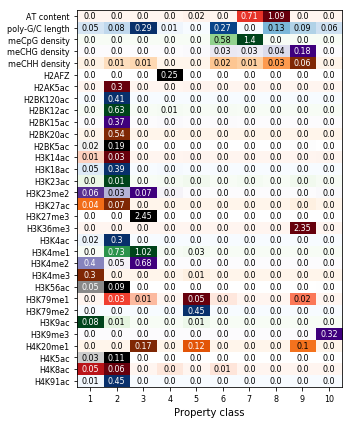

In [16]:
# plot property matrix [Extended Data Fig. 5e]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges',  'Greys']
graphics.plot_NMF_basis_matrix (H,
                                cID_list,
                                features,
                                feature_cmaps=cmaps,
                                xlabel='Property class',
                                title=None,
                                fig_width=5,
                                fig_height=6,
                                ax=None,
                                save_path='./data',
                                save=True,
                                note='H1_NCP')

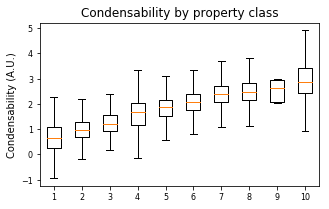

In [17]:
# plot condensability of each property class [Extended Data Fig.5e]
fig = plt.figure(figsize=(5,3))
plt.boxplot([cID_scores[cID] for cID in cID_list], 0, "")
plt.title("Condensability by property class", fontsize=12)
#plt.xlabel('Property class', fontsize=10)
plt.ylabel('Condensability (A.U.)', fontsize=10)
plt.gca().tick_params(axis='both', which='major', labelsize=8)
plt.gca().tick_params(axis='both', which='minor', labelsize=8)
plt.savefig("./data/condensability_by_class.svg", format='svg', bbox_inches='tight')
#plt.xticks(range(1, len(cID_scores)+1), range(1, len(cID_scores)+1))
#plt.tight_layout()
#plt.savefig("anatomy_pbox.png")
plt.show()
plt.close()

In [18]:
# print NMF result
f = open(out_fname + "_NMF_property_class.txt", 'w')
print >> f, "Class#" + "\t" + "\t".join(features)
for i in range(len(cID_prog)):
    print >> f, str(i+1) + "\t" + "\t".join([str(value) for value in cID_prog[i]])
f.close()

f = open(out_fname + "_NMF_NCPClass.txt", 'w')
print >> f, "ID" + "\t" + "Class#"
for ID in ID_cID:
    print >> f, str(ID) + "\t" + str(ID_cID[ID]+1)
f.close()

In [19]:
### statistical testing for comparing two NMF classes
pair_pvalue = statis.get_pvalue_pair (cID_scores, keys=cID_list)
pair_CohenD = statis.get_CohenD_pair (cID_scores, keys=cID_list)


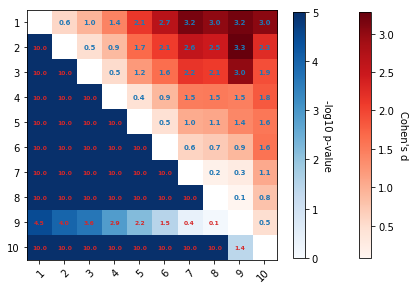

In [20]:
### plot Cohen'sd and p-value for comparing two states
graphics.plot_matrix_dual (pair_CohenD,
                           pair_pvalue,
                           keys=cID_list,
                           key_label={cID_list[i]:i+1 for i in range(len(cID_list))},
                           log_scale2='-log10',
                           dummy2=10**-10,
                           rotation=45,
                           cmap1='Reds',
                           cmap2='Blues',
                           vmin2=0,
                           vmax2=5,
                           fig_width=6,
                           fig_height=6,
                           cbar1=True,
                           cbar_label1="Cohen's d",
                           cbar2=True,
                           cbar_label2='p-value',
                           text1=True,
                           text_color1='tab:blue',
                           text_fontsize1=7,
                           decimal_pt1=1,
                           text2=True,
                           text_color2='tab:red',
                           text_fontsize2=6,
                           decimal_pt2=1,
                           save_path='./data/',
                           save=True,
                           note='H1_NCP_sp_CohenD_pavlue_NMF')